In [1]:
##################################
### Import the usual libraries ###
##################################

import numpy as np

import astropy
from astropy.io import fits, ascii
from astropy.table import Table, Column
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import astropy.constants as const
import astropy.units as u

import pandas as pd

import matplotlib
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams.update({'font.size': 16}) #make plots more readable

import MagellanicStream as ms

import dlnpyutils

import warnings
warnings.filterwarnings('ignore')

In [2]:
#find duplicates in data
def dups(data):
    list_data = list(data)
    keys = []
    values = []
    not_uniq = list(set([x for x in list_data if list_data.count(x)>1]))
    for i in range(len(not_uniq)):
        keys.append(not_uniq[i])
        values.append(np.where(data==not_uniq[i]))
    idx = dict(zip(keys, values))
    return not_uniq, idx

#calculate absolute mag
def absmag(magnitude,distance,par):
    ''' !!! Parallax must have units of mas and distances must have units of kpc!!! '''
    absm = []
    if par == True: #if distance is given as parallax
        dist = np.reciprocal(distance)*1000
        absm.append(magnitude-5.0*np.log10(dist)+5.0)
        absm = np.squeeze(np.array(absm))
    else: #if distance is given as distance
        absm.append(magnitude-5.0*np.log10(distance*1000)+5.0)
        absm = np.squeeze(np.array(absm))
    return absm

def dist2LMCtest(ra, dec, alph0, delt0, pa, io):
    ra1 = np.copy(ra)
    dec1 = np.copy(dec)
    ra1 = np.radians(ra1)
    dec1 = np.radians(dec1)
    alph0 = np.radians(alph0) #np.radians(82.25) #ra of LMC center
    delt0 = np.radians(delt0) #np.radians(-69.5) #dec of LMC center
    sd = np.sin(delt0)
    cd = np.cos(delt0)
    d0 = 49.9
    io = np.radians(io) #inclination #25.86
    pa = np.radians(pa+90) #np.radians(149.37+90)  #position angle of line-of-nodes
    cosr = cd*np.cos(dec1)*np.cos(ra1-alph0)+sd*np.sin(dec1)
    sinrcosph = -np.cos(dec1)*np.sin(ra1-alph0)
    sinrsinph = cd*np.sin(dec1)-sd*np.cos(dec1)*np.cos(ra1-alph0)
    dis = d0*np.cos(io)/(np.cos(io)*cosr-np.sin(io)*np.cos(pa)*sinrsinph+np.sin(io)*np.sin(pa)*sinrcosph)
    return dis


def sal(MH,aM):
    return MH + np.log(0.638*(10**(aM))+0.362)

def mad(dat): #median absolute deviation
    return np.median(np.absolute(dat - np.median(dat)))

In [3]:
#######################
### Age of Universe ###
#######################

'''
@article{riess2019large,
  title={Large Magellanic Cloud Cepheid Standards Provide a 1\% Foundation for the Determination of the Hubble Constant and Stronger Evidence for Physics Beyond LambdaCDM},
  author={Riess, Adam G and Casertano, Stefano and Yuan, Wenlong and Macri, Lucas M and Scolnic, Dan},
  journal={arXiv preprint arXiv:1903.07603},
  year={2019}
}
'''

#Value 74.03 \pm 1.42 (km/s)/Mpc

H0 = 74.03*(u.km/u.s)/u.Mpc
hertz = H0.to(u.km/u.s/u.pc).to(u.km/u.s/u.km)
tage = (1/hertz).to(u.yr)
ageU = tage.value

In [4]:
#########################
### Import fits files ###
#########################

#isochrone website http://stev.oapd.inaf.it/cgi-bin/cmd
''' Ages used 8 to 10.1 steps 0.15'''
''' Metallicity used -2.6 to 0.1 steps 0.099'''

parsecall = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/logisochrones.dat', \
                    format='basic', delimiter='\s')

rgb = np.where(parsecall['label']==3)
parsec = parsecall[rgb]

#DR16
lmcdr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembers_r13-l33-58672.fits',1)
clnr = np.where((lmcdr16['FE_H']>-9999.0)&(lmcdr16['AK_TARG']>-9999.0)&(lmcdr16['LOGG']>0.0)&\
                (lmcdr16['M_H_ERR']>-90.0)&(lmcdr16['C_FE']>-9999.0)&(lmcdr16['N_FE']>-9999.0))

clndr16 = lmcdr16[clnr]

#old dr16
olddr16 = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/lmc_rgbmembersdist_dr16beta.fits',1)
clnrold = np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))

clnrolddr16 = olddr16[clnrold]

#Diane Feuillet
pdfout = fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/LMC_DR16_all_PDF.fits', 1)
clnpdfout = pdfout[ np.where((olddr16['FE_H']>-9999.0)&(olddr16['AK_TARG']>-9999.0)&(olddr16['LOGG']>0.0)&\
                (olddr16['M_H_ERR']>-90.0)&(olddr16['C_FE']>-9999.0)&(olddr16['N_FE']>-9999.0))]

#Read in Christian's Model
Chrismod = ascii.read('/Users/joshpovick/Desktop/Research/Magellanic_Ages/abparam16_delgau1.5_1525.txt')

In [5]:
##################
### Twin Stars ###
##################

twin00 = np.where(clndr16['APOGEE_ID']=='2M05344888-6930585')
twin01 = np.where(clndr16['APOGEE_ID']=='2M05520333-7122418')
twin10 = np.where(clndr16['APOGEE_ID']=='2M05165283-7215137')
twin11 = np.where(clndr16['APOGEE_ID']=='2M05365273-7000382')
twin20 = np.where(clndr16['APOGEE_ID']=='2M05162027-7224421')
twin21 = np.where(clndr16['APOGEE_ID']=='2M05481203-6823387')

In [6]:
##########################
### twin stars Spectra ###
##########################
tw00=fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/asStar-r13-2M05344888-6930585.fits',0)
tw01=fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/asStar-r13-2M05520333-7122418.fits',0)
tw10=fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/asStar-r13-2M05165283-7215137.fits',0)
tw11=fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/asStar-r13-2M05365273-7000382.fits',0)
tw20=fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/asStar-r13-2M05162027-7224421.fits',0)
tw21=fits.getdata('/Users/joshpovick/Desktop/Research/Magellanic_Ages/asStar-r13-2M05481203-6823387.fits',0)

hdu=fits.open('/Users/joshpovick/Desktop/Research/Magellanic_Ages/asStar-r13-2M05344888-6930585.fits')
wav=hdu[0].header['CRVAL1']+hdu[0].header['CDELT1']*(np.arange(hdu[0].header['NWAVE'])+1-hdu[0].header['CRPIX1'])
wav=10**wav

In [7]:
test=fits.open('/Users/joshpovick/Desktop/Research/Magellanic_Ages/asStar-r13-2M05520333-7122418.fits')
# test[0].header

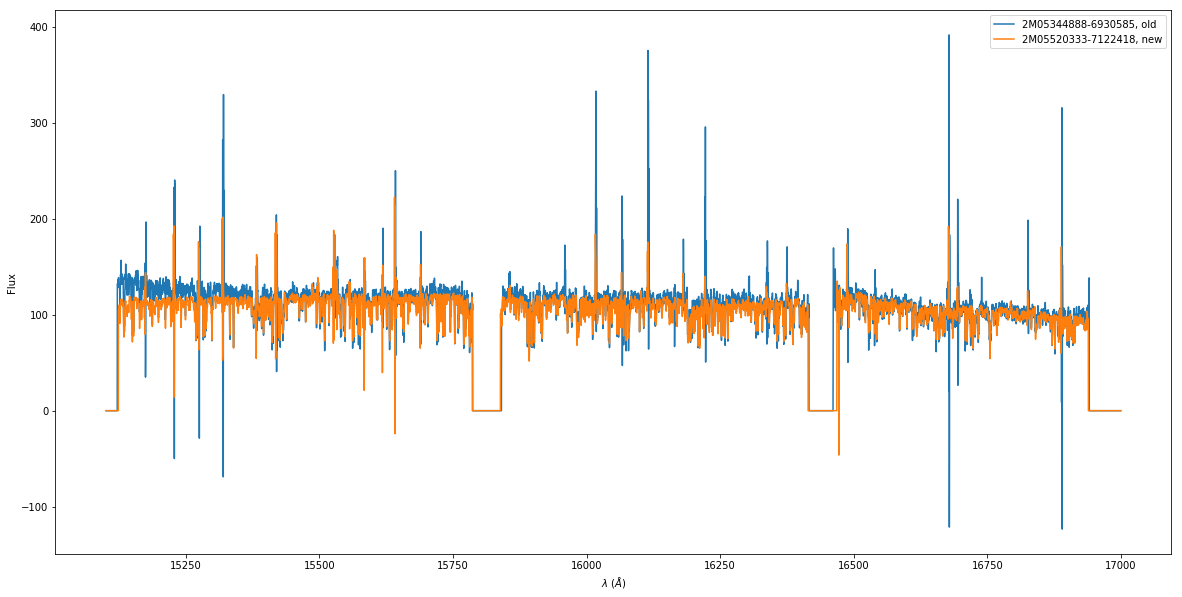

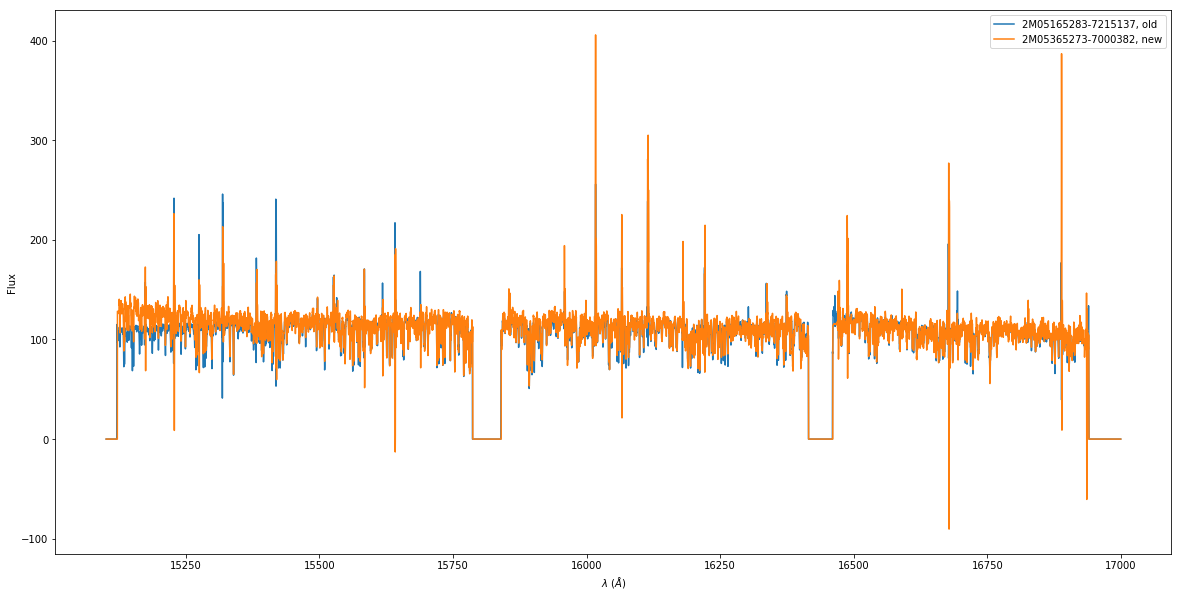

In [8]:
##################
### Twin Plots ###
##################

#2M05344888-6930585 and 2M05520333-7122418
plt.figure(figsize=[20,10])
plt.plot(wav,tw00,label='2M05344888-6930585, old')
plt.plot(wav,tw01[0],label='2M05520333-7122418, new')
plt.xlabel(r'$\lambda$ $(\AA)$')
plt.ylabel(r'Flux')
plt.legend(loc='upper right')
plt.show()

#2M05165283-7215137 and 2M05365273-7000382
plt.figure(figsize=[20,10])
plt.plot(wav,tw10[0],label='2M05165283-7215137, old')
plt.plot(wav,tw11,label='2M05365273-7000382, new')
plt.xlabel(r'$\lambda$ $(\AA)$')
plt.ylabel(r'Flux')
plt.legend(loc='upper right')
plt.show()

# #2M05162027-7224421 and 2M05841203-6823387
# plt.figure(figsize=[20,10])
# plt.plot(wav,tw20[0],label='2M05162027-7224421, old')
# plt.plot(wav,tw21[0],label='2M05841203-6823387, new')
# plt.xlabel(r'$\lambda$ $(\AA)$')
# plt.ylabel(r'Flux')
# plt.legend(loc='upper right')
# plt.show()

In [9]:
def parsec_age(w,x,y,z):
    p=[28.90025823,-0.8303683,3.28088688,-0.08771859,-7.48008086,-0.66424502,\
       0.04407313,0.13976222,0.74247359]
    return p[0]+p[1]*w+p[2]*x+p[3]*y+p[4]*z+p[5]*np.multiply(x,z)+p[6]*np.multiply(y,z)+p[7]*(x**2)+p[8]*(z**2)

In [10]:
######################
### Calculate Ages ###
######################

abd = {'C':8.39,'N':7.78,'O':8.66,'Mg':7.53,'Ca':6.31,'S':7.14,'Si':7.51,'Fe':7.45}
keys = list(abd.keys())

sol_2_H = []
for i in keys:
    sol_2_H.append(abd[i]-12.0)
    
sol_xm  = 10**np.asarray(sol_2_H)/sum(10**np.asarray(sol_2_H))
x_C = []
x_N = []
x_O = []
x_Mg = []
x_Ca = []
x_S = []
x_Si = []
x_Fe = []

for i in range(len(clndr16)):
    x_C.append(sol_xm[0]*10**(clndr16['C_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_N.append(sol_xm[1]*10**(clndr16['N_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_O.append(sol_xm[2]*10**(clndr16['O_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Mg.append(sol_xm[3]*10**(clndr16['Mg_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Ca.append(sol_xm[4]*10**(clndr16['Ca_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_S.append(sol_xm[5]*10**(clndr16['S_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Si.append(sol_xm[6]*10**(clndr16['SI_FE']+clndr16['FE_H']-clndr16['M_H']))
    x_Fe.append(sol_xm[7]*10**(clndr16['FE_H']-clndr16['M_H']))
    
facts = []
factsalp = []
factsCNO = []
factsCN = []
factsCO = []
for j in range(len(clndr16)):
    numerCN = x_C[j]+x_N[j]
    denomCN = sum(sol_xm[0:2])
    
    numerCO = x_C[j]+x_O[j]
    denomCO = sol_xm[0]+sol_xm[2]
factsCN.append(numerCN/denomCN)
factsCO.append(numerCO/denomCO)
    
# factsCN = factsCN[0]
# factsCO = factsCO[0]

metscorr = np.log10(0.638*(np.asarray(factsCN)+0.362))

stardist = dist2LMCtest(clndr16['RA'],clndr16['DEC'],82.25, -69.5, 146.37, 27.81)
corabsK = absmag(clndr16['K'],stardist,False)-clndr16['AK_TARG']
parage = parsec_age(np.log10(clndr16['TEFF']),corabsK,sal(clndr16['M_H'],metscorr),clndr16['LOGG'])
parage = np.squeeze(parage)

In [11]:
####################################
### Get Uncertainties: Add Noise ###
####################################

'''in alpha w/o C and N, out alpha w/ C and N'''

def noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,fehERR,lgg,lggERR):
    carbon = 0.28115244582676185 # derived in initial age calc
    nitrogen = 0.06901474154376043 # derived in initial age calc
    Tnoise = np.random.normal(0, 0.434*(lgTERR/lgT)) #logTeff
    Knoise = np.random.normal(0, ksERR) #Ks
    MHnoise = np.random.normal(0, mhERR) #[M/H]
    
    cm = cfe + feh - mh
    nm = nfe + feh - mh
    CMERR = np.sqrt((cfeERR)**2+(fehERR)**2+(mhERR)**2)
    NMERR = np.sqrt((nfeERR)**2+(fehERR)**2+(mhERR)**2)
    
    expcarERR = 10**(cm)*np.log(10)*CMERR
    expnitERR = 10**(nm)*np.log(10)*NMERR
    
    xcarb = carbon*10**(cm)
    xnitr = nitrogen*10**(nm)
    fac = (xcarb+xnitr)/(carbon+nitrogen) #factor from Salaris correction
    facERR = np.sqrt((expcarERR)**2+(expnitERR)**2)/(carbon+nitrogen)
    
    facnoise = np.random.normal(0, np.absolute(0.434*(facERR/fac)))
    
    lggnoise = np.random.normal(0, lggERR) #logg
    Tnew = lgT + ((-1)**np.random.randint(2))*Tnoise
    Knew = ks + ((-1)**np.random.randint(2))*Knoise
    MHnew = mh + ((-1)**np.random.randint(2))*MHnoise
    facnew = fac + ((-1)**np.random.randint(2))*facnoise
    lggnew = lgg + ((-1)**np.random.randint(2))*lggnoise
    return Tnew, Knew, MHnew, facnew, lggnew

In [12]:
######################################
### Get Uncertainties: Calc Uncert ###
######################################

devs = []

for i in range(len(clndr16)):
    lgT = np.log10(clndr16['TEFF'][i])
    lgTERR = 0.434*(np.log(clndr16['TEFF_ERR'][i])/np.log10(clndr16['TEFF'][i]))
    ks = corabsK[i]
    ksERR = clndr16['K_ERR'][i]
    mh = clndr16['M_H'][i]
    mhERR = clndr16['M_H_ERR'][i]
#     am = clndr16['ALPHA_M'][i]
#     amERR = clndr16['ALPHA_M_ERR'][i]
    cfe = clndr16['C_FE'][i]
    cfeERR = clndr16['C_FE_ERR'][i]
    nfe = clndr16['N_FE'][i]
    nfeERR = clndr16['N_FE_ERR'][i]
    feh = clndr16['FE_H'][i]
    fehERR = clndr16['FE_H_ERR'][i]
    lgg = clndr16['LOGG'][i]
    lggERR = clndr16['LOGG_ERR'][i]
    
    ages = []
    for j in range(1000):
        nlgT,nks,nmh,nfac,nlgg = noisydata(lgT,lgTERR,ks,ksERR,mh,mhERR,cfe,cfeERR,nfe,nfeERR,feh,\
                                          fehERR,lgg,lggERR)
        ages.append(parsec_age(nlgT,nks,sal(nmh,nfac),nlgg))
    
    devs.append(mad(ages))

In [13]:
parsec.columns

<TableColumns names=('Zini','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

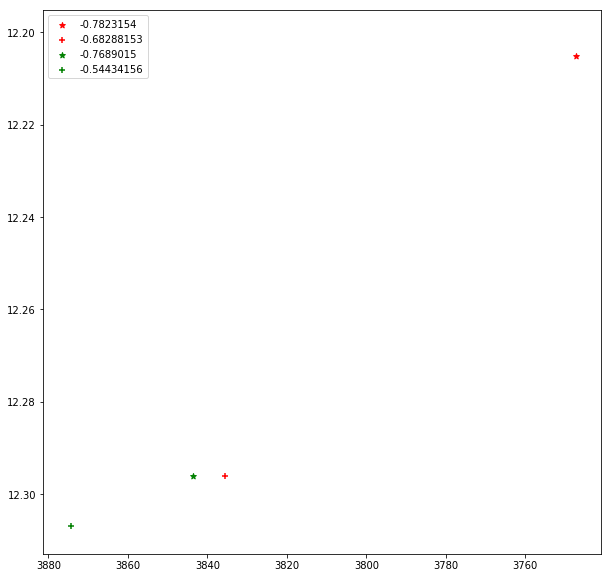

In [14]:
##################
### HR of Twins ### 
###################

plt.figure(figsize=[10,10])
# plt.scatter(10**parsec['logTe'],parsec['Ksmag'],alpha=0.75)
plt.scatter(clndr16[twin00]['TEFF'],clndr16[twin00]['K'],marker='*',c='r',label='-0.7823154')
plt.scatter(clndr16[twin01]['TEFF'],clndr16[twin01]['K'],marker='+',c='r',label='-0.68288153')
plt.scatter(clndr16[twin10]['TEFF'],clndr16[twin10]['K'],marker='*',c='g',label='-0.7689015')
plt.scatter(clndr16[twin11]['TEFF'],clndr16[twin11]['K'],marker='+',c='g',label='-0.54434156')
# plt.scatter(clndr16[twin20]['TEFF'],clndr16[twin20]['K'],marker='*',c='b',label='-1.2391615')
# plt.scatter(clndr16[twin21]['TEFF'],clndr16[twin21]['K'],marker='+',c='b',label='-0.68485515')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.legend(loc='upper left')
plt.show()

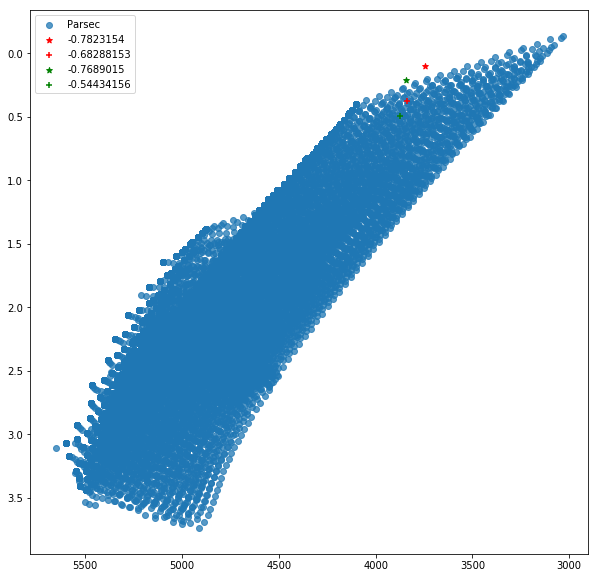

In [15]:
plt.figure(figsize=[10,10])
plt.scatter(10**parsec['logTe'],parsec['logg'],alpha=0.75,label='Parsec')
plt.scatter(clndr16[twin00]['TEFF'],clndr16[twin00]['LOGG'],marker='*',c='r',label='-0.7823154')
plt.scatter(clndr16[twin01]['TEFF'],clndr16[twin01]['LOGG'],marker='+',c='r',label='-0.68288153')
plt.scatter(clndr16[twin10]['TEFF'],clndr16[twin10]['LOGG'],marker='*',c='g',label='-0.7689015')
plt.scatter(clndr16[twin11]['TEFF'],clndr16[twin11]['LOGG'],marker='+',c='g',label='-0.54434156')
# plt.scatter(clndr16[twin20]['TEFF'],clndr16[twin20]['K'],marker='*',c='b',label='-1.2391615')
# plt.scatter(clndr16[twin21]['TEFF'],clndr16[twin21]['K'],marker='+',c='b',label='-0.68485515')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.legend(loc='upper left')
plt.show()

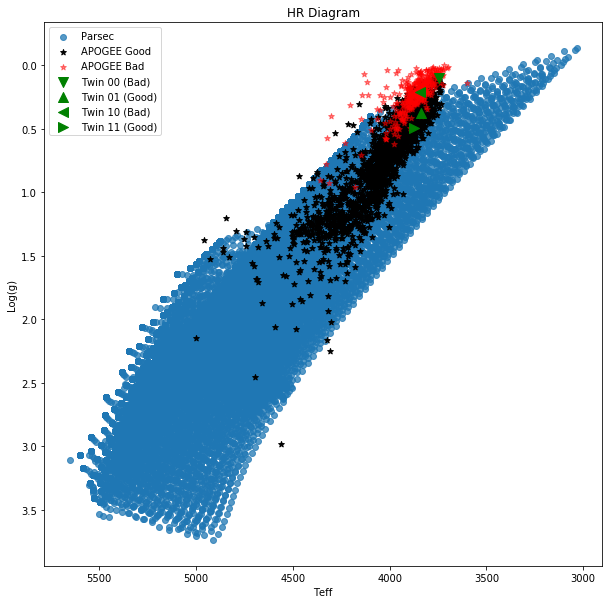

In [16]:
senex = np.where(parage >= (10.13+max(devs)))
iuvenis = np.where(parage <= (10.13+max(devs)))

plt.figure(figsize=[10,10])
plt.scatter(10**parsec['logTe'],parsec['logg'],alpha=0.75,label='Parsec')
plt.scatter(clndr16['TEFF'][iuvenis],clndr16['LOGG'][iuvenis],marker='*',c='k',label='APOGEE Good')
plt.scatter(clndr16['TEFF'][senex],clndr16['LOGG'][senex],marker='*',c='r',label='APOGEE Bad',alpha=0.5)
plt.scatter(clndr16['TEFF'][twin00],clndr16['LOGG'][twin00],marker='v',c='g',s=100,label='Twin 00 (Bad)')
plt.scatter(clndr16['TEFF'][twin01],clndr16['LOGG'][twin01],marker='^',c='g',s=100,label='Twin 01 (Good)')
plt.scatter(clndr16['TEFF'][twin10],clndr16['LOGG'][twin10],marker='<',c='g',s=100,label='Twin 10 (Bad)')
plt.scatter(clndr16['TEFF'][twin11],clndr16['LOGG'][twin11],marker='>',c='g',s=100,label='Twin 11 (Good)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel(r'Log(g)')
plt.xlabel(r'Teff')
plt.title(r'HR Diagram')
plt.legend(loc='upper left')
plt.savefig('twinhrdiagram.pdf',bbox_inches='tight')
plt.show()

In [17]:
parsec.columns

<TableColumns names=('Zini','logAge','Mini','int_IMF','Mass','logL','logTe','logg','label','McoreTP','C_O','period0','period1','pmode','Mloss','tau1m','X','Y','Xc','Xn','Xo','Cexcess','Z','mbolmag','Jmag','Hmag','Ksmag')>

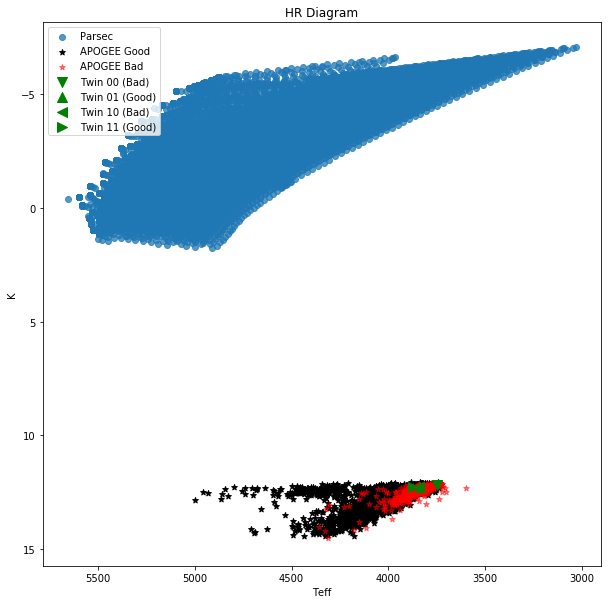

In [18]:
plt.figure(figsize=[10,10])
plt.scatter(10**parsec['logTe'],parsec['Ksmag'],alpha=0.75,label='Parsec')
plt.scatter(clndr16['TEFF'][iuvenis],clndr16['K'][iuvenis],marker='*',c='k',label='APOGEE Good')
plt.scatter(clndr16['TEFF'][senex],clndr16['K'][senex],marker='*',c='r',label='APOGEE Bad',alpha=0.5)
plt.scatter(clndr16['TEFF'][twin00],clndr16['K'][twin00],marker='v',c='g',s=100,label='Twin 00 (Bad)')
plt.scatter(clndr16['TEFF'][twin01],clndr16['K'][twin01],marker='^',c='g',s=100,label='Twin 01 (Good)')
plt.scatter(clndr16['TEFF'][twin10],clndr16['K'][twin10],marker='<',c='g',s=100,label='Twin 10 (Bad)')
plt.scatter(clndr16['TEFF'][twin11],clndr16['K'][twin11],marker='>',c='g',s=100,label='Twin 11 (Good)')
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.ylabel(r'K')
plt.xlabel(r'Teff')
plt.title(r'HR Diagram')
plt.legend(loc='upper left')
# plt.savefig('twinhrdiagram.pdf',bbox_inches='tight')
plt.show()

In [19]:
max(parsec['Ksmag'])

1.773

In [20]:
print('First Pair')
print('Old Star Age (Gyr)',10**parage[twin00]/10**9)
print('Young Star Age (Gyr)',10**parage[twin01]/10**9)
print('Old Star [C/Fe]',clndr16[twin00]['C_FE'])
print('Young Star [C/Fe]',clndr16[twin01]['C_FE'])
print('Old Star Log(g)',clndr16[twin00]['LOGG'])
print('Young Star Log(g)',clndr16[twin01]['LOGG'])
print('Old Star K',clndr16[twin00]['K'])
print('Young Star K',clndr16[twin01]['K'])
print('Old Star [Fe/H]',clndr16[twin00]['FE_H'])
print('Young Star [Fe/H]',clndr16[twin01]['FE_H'])
print('Old Star Teff',clndr16[twin00]['TEFF'])
print('Young Star Teff',clndr16[twin01]['TEFF'])
print('-')

print('Second Pair')
print('Old Star Age (Gyr)',10**parage[twin10]/10**9)
print('Young Star Age (Gyr)',10**parage[twin11]/10**9)
print('Old Star [C/Fe]',clndr16[twin10]['C_FE'])
print('Young Star [C/Fe]',clndr16[twin11]['C_FE'])
print('Old Star Log(g)',clndr16[twin10]['LOGG'])
print('Young Star Log(g)',clndr16[twin11]['LOGG'])
print('Old Star K',clndr16[twin10]['K'])
print('Young Star K',clndr16[twin11]['K'])
print('Old Star [Fe/H]',clndr16[twin10]['FE_H'])
print('Young Star [Fe/H]',clndr16[twin11]['FE_H'])
print('Old Star Teff',clndr16[twin10]['TEFF'])
print('Young Star Teff',clndr16[twin11]['TEFF'])
print('-')

# print('Third Pair')
# print('Old Star Teff',10**parage[twin20]/10**9)
# print('Young Star Teff',10**parage[twin21]/10**9)
# print('Old Star [C/Fe]',clndr16[twin20]['C_FE'])
# print('Young Star [C/Fe]',clndr16[twin21]['C_FE'])
# print('Old Star Log(g)',clndr16[twin20]['LOGG'])
# print('Young Star Log(g)',clndr16[twin21]['LOGG'])
# print('Old Star K',clndr16[twin20]['K'])
# print('Young Star K',clndr16[twin21]['K'])
# print('Old Star [Fe/H]',clndr16[twin20]['FE_H'])
# print('Young Star [Fe/H]',clndr16[twin21]['FE_H'])
# print('Old Star Teff',clndr16[twin20]['TEFF'])
# print('Young Star Teff',clndr16[twin21]['TEFF'])
# print('-')

First Pair
Old Star Age (Gyr) [13.36959117]
Young Star Age (Gyr) [6.89274921]
Old Star [C/Fe] [-0.34566003]
Young Star [C/Fe] [-0.16711003]
Old Star Log(g) [0.10285673]
Young Star Log(g) [0.37361458]
Old Star K [12.205]
Young Star K [12.296]
Old Star [Fe/H] [-0.78023154]
Young Star [Fe/H] [-0.68288153]
Old Star Teff [3747.336]
Young Star Teff [3835.624]
-
Second Pair
Old Star Age (Gyr) [18.5819789]
Young Star Age (Gyr) [2.30435713]
Old Star [C/Fe] [-0.3424]
Young Star [C/Fe] [-0.20865]
Old Star Log(g) [0.21108483]
Young Star Log(g) [0.49641532]
Old Star K [12.296]
Young Star K [12.307]
Old Star [Fe/H] [-0.7689015]
Young Star [Fe/H] [-0.54434156]
Old Star Teff [3843.4937]
Young Star Teff [3874.4077]
-


In [21]:
10**clndr16[twin00]['M_H']

array([0.16084532], dtype=float32)

In [22]:
10**(clndr16[twin00]['C_FE']+clndr16[twin00]['FE_H'])

array([0.07483564], dtype=float32)

In [23]:
10**clndr16[twin00]['FE_H']

array([0.16587023], dtype=float32)

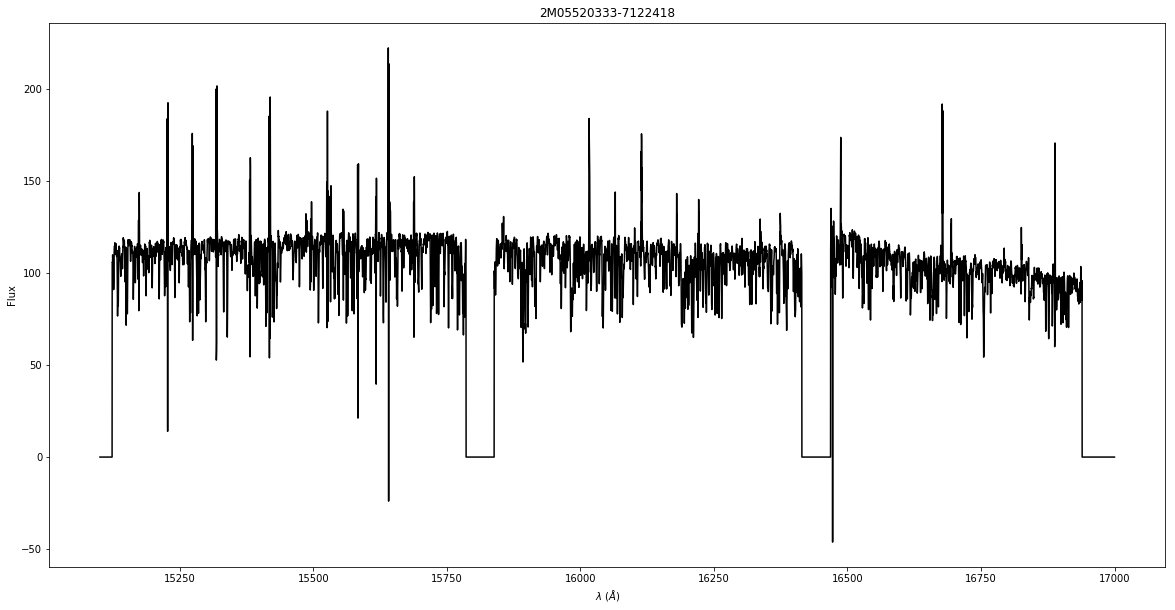

In [24]:
#2M05520333-7122418
plt.figure(figsize=[20,10])
plt.plot(wav,tw01[0],color='k')
plt.xlabel(r'$\lambda$ $(\AA)$')
plt.ylabel(r'Flux')
plt.title(r'2M05520333-7122418')
plt.savefig('spectraexample.jpg',bbox_inches='tight')
plt.show()

In [25]:
min(clndr16['LOGG'])

3.5826117e-05